In [4]:
%matplotlib inline

import numpy as np
import datetime as dt
import pandas as pd
import os
import xarray as xr
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, save
from bokeh.io import reset_output
import bokeh
import properscoring as ps

from tonic.io import read_config, read_configobj
from plot_utils import read_USGS_data, read_RVIC_output, kge, nse, rmse, nensk, crps

In [5]:
# ===================================================== #
# Read cfg
# ===================================================== #
cfg = read_configobj(
    'cfg/20180618.post_dual.ArkRed.GPM.LAI_from_veglib.smap_with_winter_longtermRescale/'
    'prec_std1_phi0/plot_routed.sm_0.5.N32.no_sm3_update_only.cfg')

In [3]:
# ===================================================== #
# Parameters
# ===================================================== #
# --- USGS data --- #
# Site info file; needs to have columns "short_name" and "site_no"
site_info_csv = cfg['USGS']['site_info_csv']
# Directory of USGS data
usgs_data_dir = cfg['USGS']['usgs_data_dir']

# --- Routed --- #
# Openloop nc
openloop_nc = cfg['ROUTE']['openloop_nc']

# Ensemble size
N = cfg['ROUTE']['N']
# Ensemble nc; "{}" will be replaced by ensemble index
ensemble_basenc = cfg['ROUTE']['ensemble_basenc']

# Time lag of routed data with local time [hours];
# Example: if local time is UTC-6 (ArkRed) and routed data is in UTC, then time_lag = 6
time_lag = cfg['ROUTE']['time_lag']

# --- Time --- #
start_time = pd.to_datetime(cfg['ROUTE']['start_time'])
end_time = pd.to_datetime(cfg['ROUTE']['end_time'])
start_year = start_time.year
end_year = end_time.year

# --- Zero-update --- #
# Zero-update ensemble nc; "{}" will be replaced by ensemble index
zero_update_ensemble_basenc = cfg['ROUTE']['zero_update_ensemble_basenc']

# --- Domain file ("mask" and "area" will be used) --- #
domain_nc = cfg['DOMAIN']['domain_nc']

# --- RVIC output param remap nc files --- #
# "{}" will be replaced by site name
rvic_subbasin_nc = cfg['DOMAIN']['rvic_subbasin_nc']

# --- VIC forcing file basedir ("YYYY.nc" will be appended) --- #
force_basedir = cfg['BASEFLOW_FRAC']['force_basedir']

# --- VIC opnloop output history nc (this is to calculate baseflow fraction) --- #
vic_openloop_hist_nc = cfg['BASEFLOW_FRAC']['vic_openloop_hist_nc']

# --- Output --- #
output_dir = cfg['OUTPUT']['output_dir']

NameError: name 'cfg' is not defined

In [5]:
# ===================================================== #
# Load USGS data
# ===================================================== #
# --- Load site info --- #
df_site_info = pd.read_csv(site_info_csv, dtype={'site_no': str})
dict_sites = {}  # {site: site_no}
for i in df_site_info.index:
    site = df_site_info.loc[i, 'short_name']
    site_no = df_site_info.loc[i, 'site_no']
    dict_sites[site] = site_no
    
# --- Load USGS streamflow data --- #
dict_flow_usgs = {}  # {site: ts}
for site in dict_sites.keys():
    print('Loading USGS data for site {}...'.format(site))
    site_no = dict_sites[site]
    filename = os.path.join(usgs_data_dir, '{}.txt'.format(site_no))
    ts_flow = read_USGS_data(filename, columns=[1], names=['flow'])['flow']
    dict_flow_usgs[site] = ts_flow.truncate(before=start_time, after=end_time)

# --- Get USGS drainage area (mi2) --- #
dict_usgs_drainage_area = {}  # {site: area}
for i in df_site_info.index:
    site = df_site_info.loc[i, 'short_name']
    drainage_area = df_site_info.loc[i, 'drain_area_va']
    dict_usgs_drainage_area[site] = drainage_area * 1.60934 * 1.60934  # convert [mi2] to [km2]

Loading USGS data for site arkansas...
Loading USGS data for site deep...
Loading USGS data for site spring...
Loading USGS data for site bird...
Loading USGS data for site ninnescah...
Loading USGS data for site chikaskia...
Loading USGS data for site walnut...
Loading USGS data for site illinois...


In [6]:
# ===================================================== #
# Load and process routed data
# ===================================================== #
# --- Load openloop data --- #
df_openloop, dict_outlet = read_RVIC_output(openloop_nc)

# --- Load ensemble data --- #
list_da_ensemble = []
for i in range(N):
    filename = ensemble_basenc.format(i+1)
    df, dict_outlet = read_RVIC_output(filename)
    da = xr.DataArray(df, dims=['time', 'site'])
    list_da_ensemble.append(da)
# Concat all ensemble members
da_ensemble = xr.concat(list_da_ensemble, dim='N')

# --- Load zero-update data --- #
list_da_ensemble = []
for i in range(N):
    filename = zero_update_ensemble_basenc.format(i+1)
    df, dict_outlet = read_RVIC_output(filename)
    da = xr.DataArray(df, dims=['time', 'site'])
    list_da_ensemble.append(da)
# Concat all ensemble members
da_zero_update_ensemble = xr.concat(list_da_ensemble, dim='N')

# --- Shift all routed data data to local time --- #
df_openloop.index = df_openloop.index - pd.DateOffset(hours=time_lag)
da_ensemble['time'] = pd.to_datetime(da_ensemble['time'].values) - pd.DateOffset(hours=time_lag)
da_zero_update_ensemble['time'] = \
    pd.to_datetime(da_zero_update_ensemble['time'].values) - pd.DateOffset(hours=time_lag)

# --- Average all routed data to daily (of local time) --- #
df_openloop_daily = df_openloop.resample('1D', how='mean')
da_ensemble_daily = da_ensemble.resample('1D', dim='time', how='mean')
da_zero_update_ensemble_daily = da_zero_update_ensemble.resample('1D', dim='time', how='mean')

# --- Calculate ensemble mean --- #
da_ensMean_daily = da_ensemble_daily.mean(dim='N')
da_zero_update_ensMean_daily = da_zero_update_ensemble_daily.mean(dim='N')

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="1D").mean() 
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:35: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="1D").mean() 


In [7]:
# ===================================================== #
# Load basin information
# ===================================================== #
ds_domain = xr.open_dataset(domain_nc)
da_area = ds_domain['area']
da_domain = ds_domain['mask']

# --- Basin domain --- #
dict_da_frac = {}
for site in dict_sites.keys():
    da_frac = xr.open_dataset(rvic_subbasin_nc.format(site))['fraction']
    dict_da_frac[site] = da_frac

# --- Basin area --- #
dict_basin_area = {}
for site in dict_sites.keys():
    basin_area = float(da_area.where(dict_da_frac[site]>0).sum())  # [m2]
    basin_area = basin_area / 1000 / 1000  # convert to [km2]
    dict_basin_area[site] = basin_area
    print(site, basin_area)

arkansas 3489.61244685949
deep 4863.3081974647885
spring 5075.144257650728
bird 3103.7095348407056
ninnescah 1983.1028074048015
chikaskia 4310.18946663719
walnut 5043.581406236542
illinois 3276.8724308692413


/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [8]:
# ===================================================== #
# Calculate basin monthly runoff ratio
# ===================================================== #
# --- Load precipitation data --- #
list_da_prec = []
for year in range(start_year, end_year+1):
    da = xr.open_dataset(
        '{}{}.nc'.format(force_basedir, year))['PREC']
    list_da_prec.append(da)
da_prec = xr.concat(list_da_prec, dim='time').sel(time=slice(start_time, end_time))
da_prec_mon = da_prec.resample('1M', dim='time', how='sum')  # [mm/month]

dict_runoff_ratio_openloop_routed_mon = {}
dict_runoff_ratio_usgs_mon = {}
for site in dict_sites.keys():
    # Precipitation sum
    da_basin_prec_mon = da_prec_mon.where(dict_da_frac[site]>0)
    ts_basin_prec_mon = (da_basin_prec_mon * da_area).sum(
        dim='lat').sum(dim='lon').to_series()  # [mm*m2/mon]
    ts_basin_prec_mon = ts_basin_prec_mon * 1000 * 1000 \
        / np.power(25.4*12, 3) / (365/12 * 86400)  # converted to [cfs]
    # Streamflow
    ts_openloop_routed_mon = df_openloop_daily.loc[:, site].resample('1M', how='mean')  # [cfs]
    ts_usgs_mon = dict_flow_usgs[site].resample('1M', how='mean')  # [cfs]
    # Monthly runoff ratio
    dict_runoff_ratio_openloop_routed_mon[site] = ts_openloop_routed_mon / ts_basin_prec_mon
    dict_runoff_ratio_usgs_mon[site] = ts_usgs_mon / ts_basin_prec_mon

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="sum", instead consider using .resample(time="1M").sum() 
  # This is added back by InteractiveShellApp.init_path()
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:22: FutureWarning: how in .resample() is deprecated
the new syntax is .resample

In [9]:
# ===================================================== #
# Calculate basin baseflow fraction (average baseflow / total runoff)
# ===================================================== #
# --- Load openloop VIC runoff --- #
ds_openloop = xr.open_dataset(vic_openloop_hist_nc)
da_totrunoff = ds_openloop['OUT_RUNOFF'] + ds_openloop['OUT_BASEFLOW']
da_baseflow = ds_openloop['OUT_BASEFLOW']

In [10]:
# --- Calculate basin-avg baseflow fraction --- #
dict_baseflow_fraction = {}
for site in dict_sites.keys():
    # Baseflow sum
    da_basin_baseflow = da_baseflow.where(dict_da_frac[site]>0)
    basin_baseflow = (da_basin_baseflow * da_area).sum(
        dim='lat').sum(dim='lon').mean(dim='time').values  # [mm*m2/step]
    # Total runoff sum
    da_basin_totrunoff = da_totrunoff.where(dict_da_frac[site]>0)
    basin_totrunoff = (da_basin_totrunoff * da_area).sum(
        dim='lat').sum(dim='lon').mean(dim='time').values  # [mm*m2/step]
    # Baseflow fraction
    baseflow_fraction = basin_baseflow / basin_totrunoff
    dict_baseflow_fraction[site] = baseflow_fraction

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


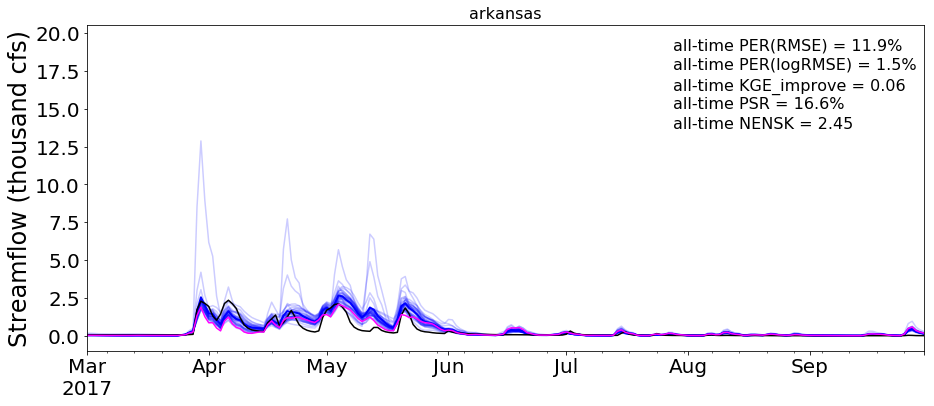

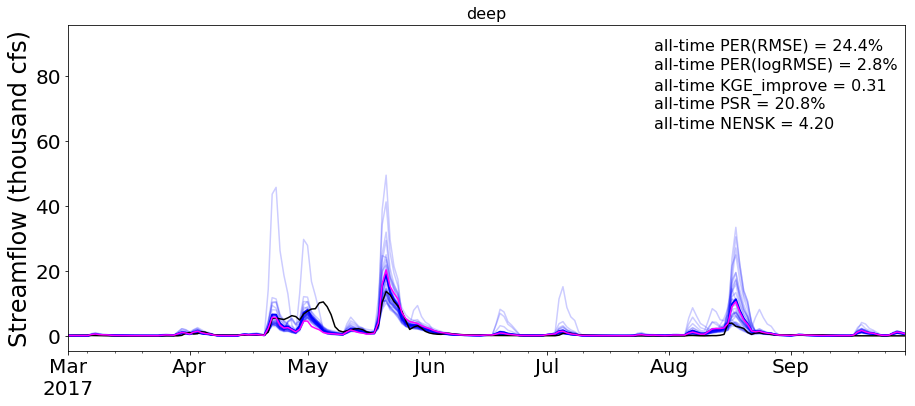

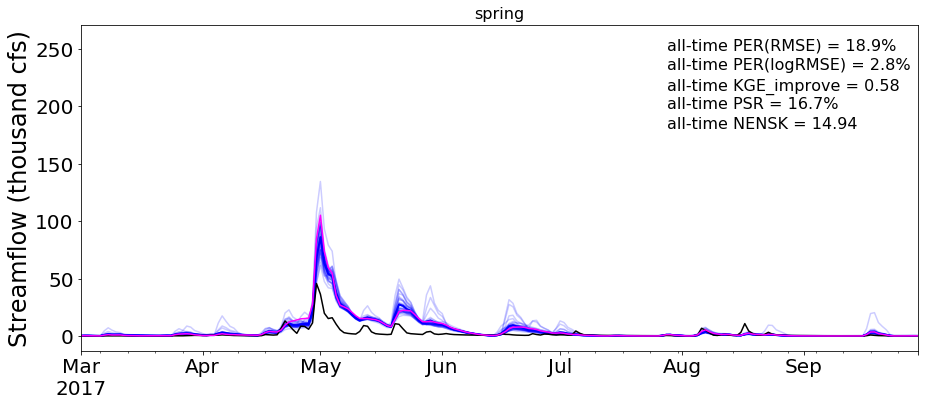

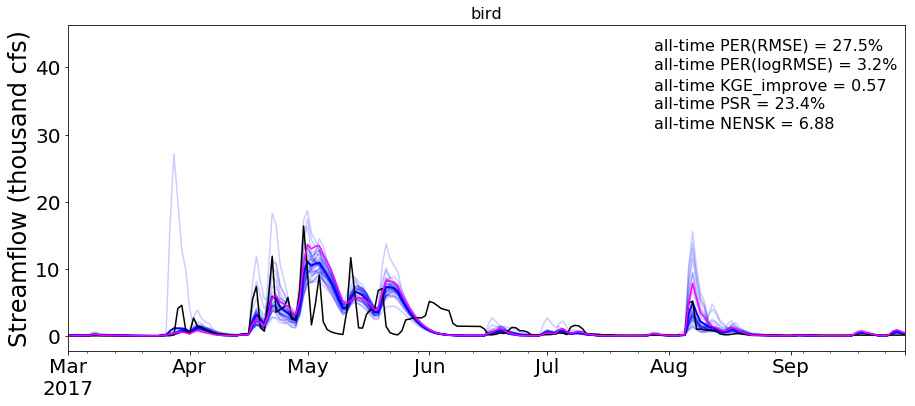

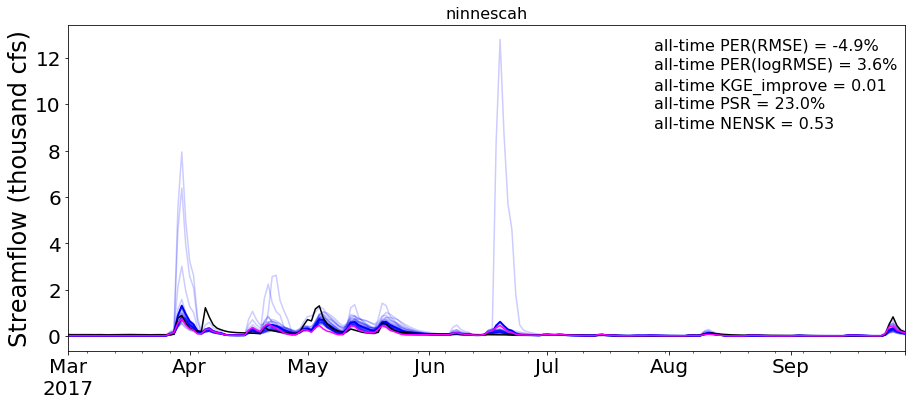

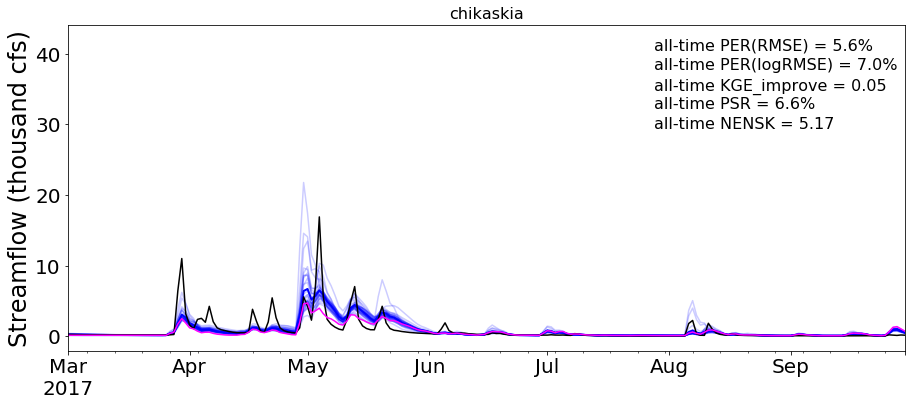

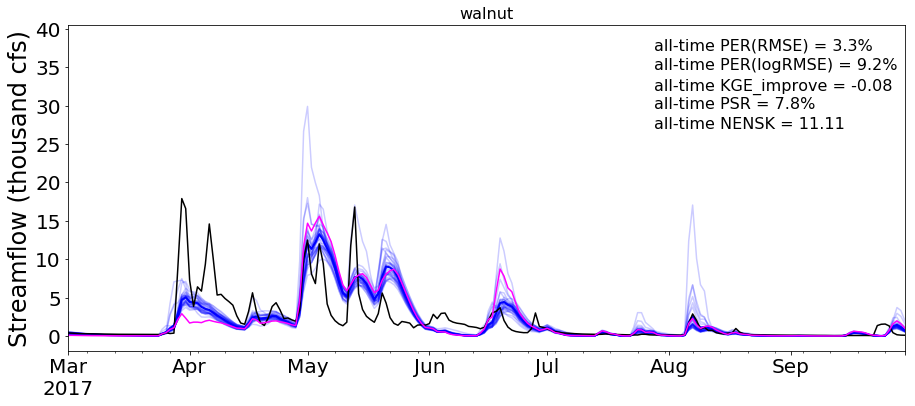

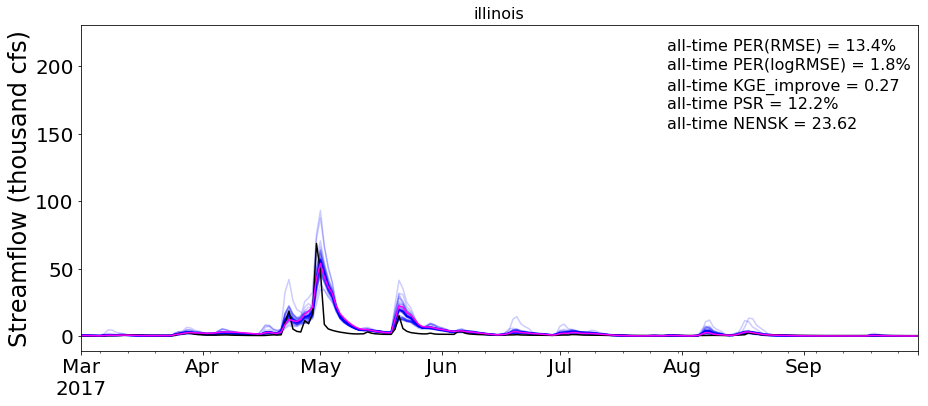

In [23]:
# ===================================================== #
# Plot
# ===================================================== #
for site in dict_sites.keys():
    # --- Some calculation --- #
    ts_usgs = dict_flow_usgs[site]
    ts_openloop = df_openloop_daily.loc[:, site]
    ts_usgs = ts_usgs[ts_openloop.index].dropna()
    ts_openloop = ts_openloop[ts_usgs.index].dropna()
    ts_ensMean = da_ensMean_daily.sel(site=site).to_series()[ts_usgs.index].dropna()
    ensemble_daily = da_ensemble_daily.sel(
        site=site, time=ts_usgs.index).transpose('time', 'N').values
    zero_update_ensemble_daily = da_zero_update_ensemble_daily.sel(
        site=site, time=ts_usgs.index).transpose('time', 'N').values
    # PER(RMSE)
    rmse_openloop = rmse(ts_openloop, ts_usgs)
    rmse_ensMean = rmse(ts_ensMean, ts_usgs)
    per_RMSE = (1 - rmse_ensMean / rmse_openloop) * 100
    # PER(logRMSE)
    rmseLog_openloop = rmse(np.log(ts_openloop+1), np.log(ts_usgs+1))
    rmseLog_ensMean = rmse(np.log(ts_ensMean+1), np.log(ts_usgs+1))
    per_logRMSE = (1 - rmseLog_ensMean / rmseLog_openloop) * 100
    # PSR
    crps_ens = crps(ts_usgs, ensemble_daily)
    crps_zero_update = crps(ts_usgs, zero_update_ensemble_daily)
    psr = (1 - crps_ens / crps_zero_update) * 100
    # Normalized ensemble skill (NENSK)
    nensk_ens = nensk(ts_usgs, ensemble_daily)
    # KGE improvement
    kge_openloop = kge(ts_openloop, ts_usgs)
    kge_ensMean = kge(ts_ensMean, ts_usgs)
    kge_improv = kge_ensMean - kge_openloop
    
    # --- Plot - regular --- #
    fig = plt.figure(figsize=(15, 6))
    ax = plt.axes()
    # Ensemble
    for i in range(N):
        ts = da_ensemble_daily.sel(N=i, site=site).to_series() / 1000
        ts.plot(color='blue', alpha=0.2)
    (ts_ensMean/1000).plot(color='blue', linewidth=2)
    # USGS
    (ts_usgs / 1000).plot(color='black')
    # Openloop
    (ts_openloop / 1000).plot(
        color='magenta', style='-')
    # Add text about metrics
    plt.text(0.7, 0.96,
             "all-time PER(RMSE) = {:.1f}%\n".format(per_RMSE),
             horizontalalignment='left',
             verticalalignment='top', transform=ax.transAxes, fontsize=16)
    plt.text(0.7, 0.9,
             "all-time PER(logRMSE) = {:.1f}%\n".format(per_logRMSE),
             horizontalalignment='left',
             verticalalignment='top', transform=ax.transAxes, fontsize=16)
    plt.text(0.7, 0.84,
             "all-time KGE_improve = {:.2f}\n".format(kge_improv),
             horizontalalignment='left',
             verticalalignment='top', transform=ax.transAxes, fontsize=16)
    plt.text(0.7, 0.78,
             "all-time PSR = {:.1f}%\n".format(psr),
             horizontalalignment='left',
             verticalalignment='top', transform=ax.transAxes, fontsize=16)
    plt.text(0.7, 0.72,
             "all-time NENSK = {:.2f}\n".format(nensk_ens),
             horizontalalignment='left',
             verticalalignment='top', transform=ax.transAxes, fontsize=16)
    # Make plot better
    plt.xlim(['2017-03-01', '2017-09-30'])
    plt.ylabel('Streamflow (thousand cfs)', fontsize=24)
    plt.xlabel("", fontsize=16)
    plt.title(site, fontsize=16)
    for t in ax.get_xticklabels():
        t.set_fontsize(20)
    for t in ax.get_yticklabels():
        t.set_fontsize(20)
    # Save to file
    fig.savefig(os.path.join(output_dir, 'flow_daily.improve.zoomin.{}.png'.format(site)),
                format='png', bbox_inches='tight', pad_inches=0)
    
    # --- Interactive --- #
    output_file(os.path.join(output_dir, 'flow_daily.improve.{}.html'.format(site)))
    p = figure(title=('Streamflow at {}\n'
                      'PER(RMSE)={:.1f}%, PER(RMSElog)={:.1f}%, KGE_improve={:.2f}, '
                      'PSR = {:.1f}%, NENSK={:.2f}').format(
                    site, per_RMSE, per_logRMSE, kge_improv, psr, nensk_ens),
               x_axis_label="Time", y_axis_label="Streamflow (thousand csv)",
               x_axis_type='datetime', width=1000, height=500)
    # plot ensemble
    for i in range(N):
        label = 'Ensemble updated' if i == 0 else '_nolegend_'
        ts = da_ensemble_daily.sel(N=i, site=site).to_series() / 1000
        p.line(ts.index, ts.values, color="blue", line_dash="solid",
               alpha=0.2, line_width=2, legend=label)
    p.line(ts_ensMean.index, (ts_ensMean/1000).values, color="blue", line_dash="solid",
           line_width=2, legend=label)
    # plot USGS
    p.line(ts_usgs.index, (ts_usgs/1000).values, color="black", line_dash="solid",
           legend="USGS", line_width=2)
    # plot open-loop
    p.line(ts_openloop.index, (ts_openloop/1000).values, color="magenta", line_dash="dashed",
           legend='Open-loop',
           line_width=2)
    # Save
    save(p)

# Plots for paper

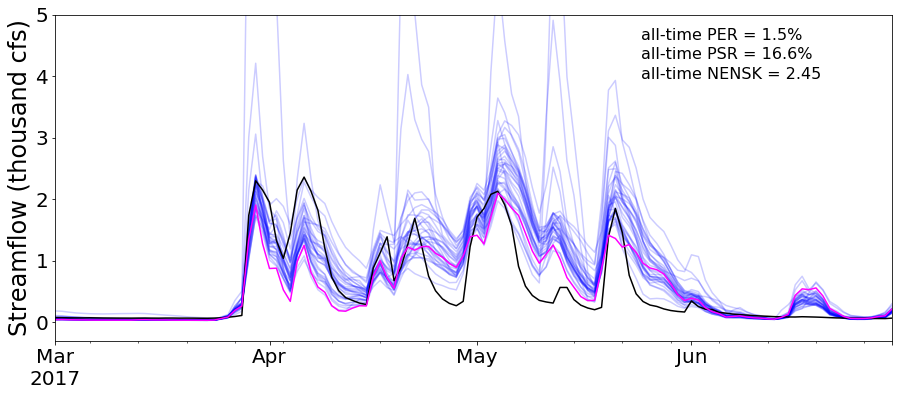

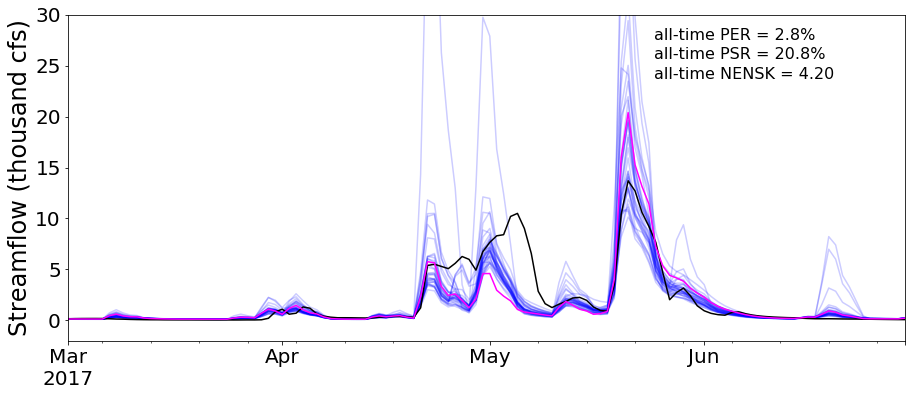

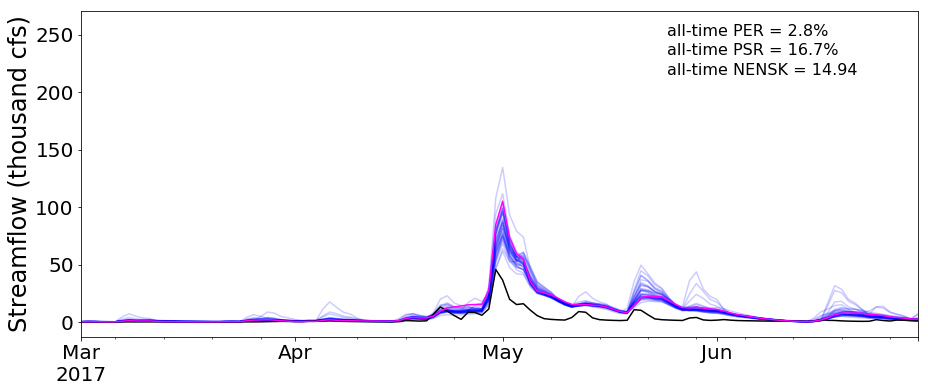

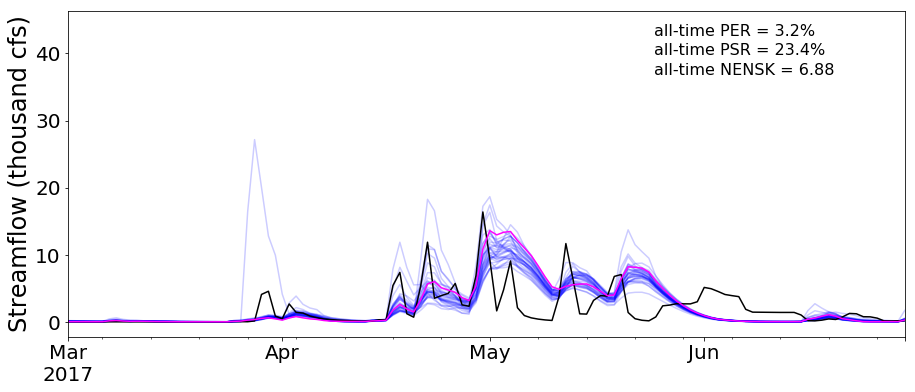

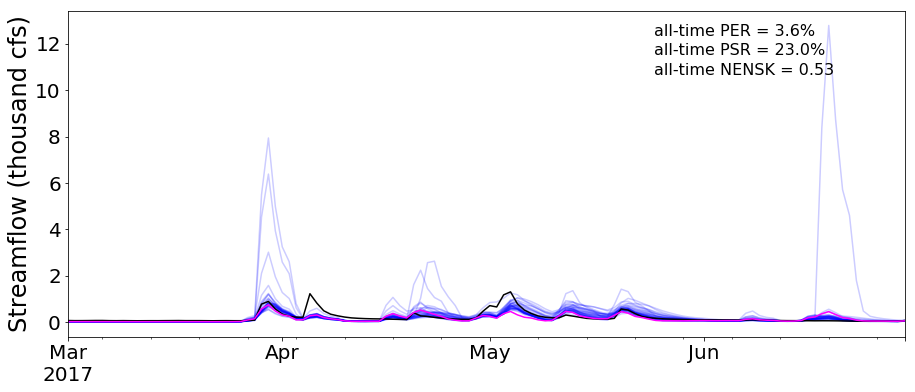

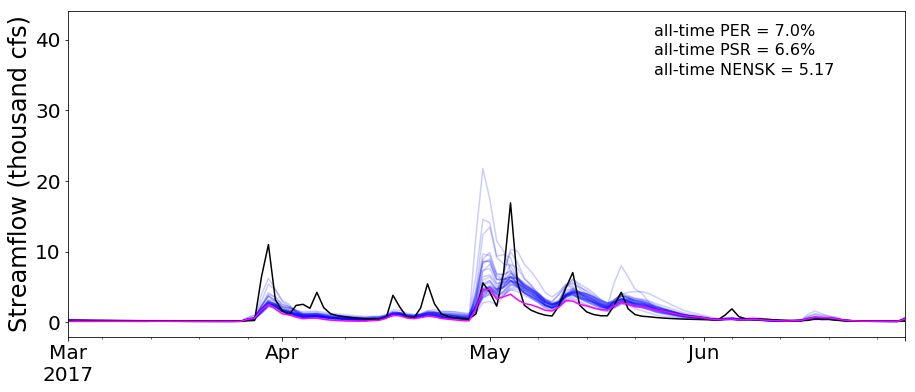

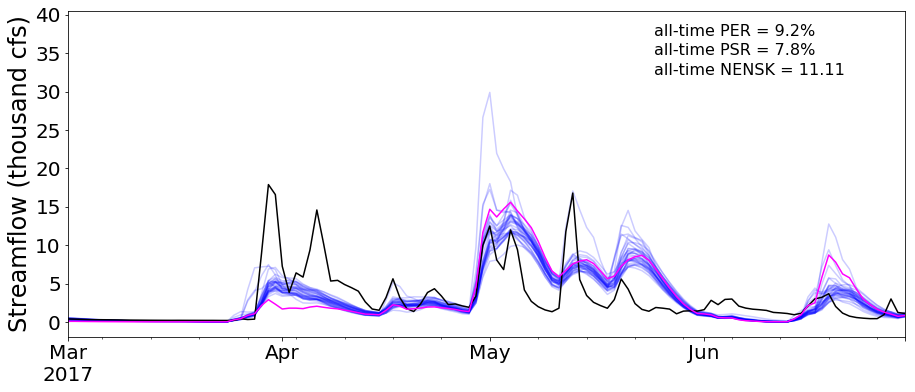

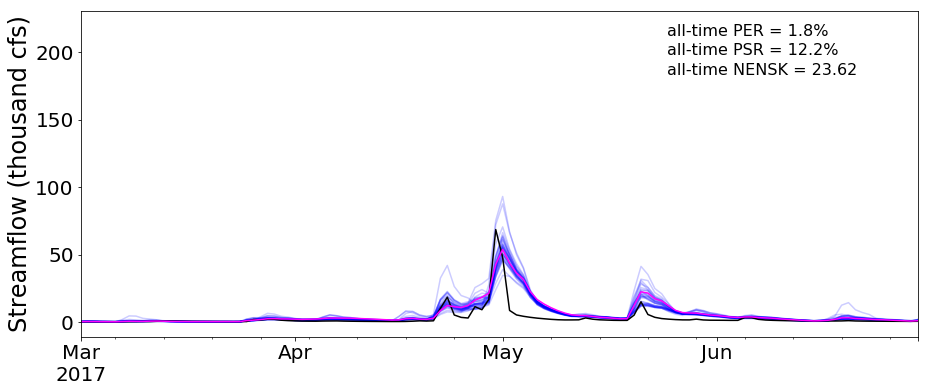

In [11]:
# ===================================================== #
# Plot
# ===================================================== #
for site in dict_sites.keys():
    # --- Some calculation --- #
    ts_usgs = dict_flow_usgs[site]
    ts_openloop = df_openloop_daily.loc[:, site]
    ts_usgs = ts_usgs[ts_openloop.index].dropna()
    ts_openloop = ts_openloop[ts_usgs.index].dropna()
    ts_ensMean = da_ensMean_daily.sel(site=site).to_series()[ts_usgs.index].dropna()
    ensemble_daily = da_ensemble_daily.sel(
        site=site, time=ts_usgs.index).transpose('time', 'N').values
    zero_update_ensemble_daily = da_zero_update_ensemble_daily.sel(
        site=site, time=ts_usgs.index).transpose('time', 'N').values
    # PER
    rmseLog_openloop = rmse(np.log(ts_openloop+1), np.log(ts_usgs+1))
    rmseLog_ensMean = rmse(np.log(ts_ensMean+1), np.log(ts_usgs+1))
    per = (1 - rmseLog_ensMean / rmseLog_openloop) * 100
    # PSR
    crps_ens = crps(ts_usgs, ensemble_daily)
    crps_zero_update = crps(ts_usgs, zero_update_ensemble_daily)
    psr = (1 - crps_ens / crps_zero_update) * 100
    # Normalized ensemble skill (NENSK)
    nensk_ens = nensk(ts_usgs, ensemble_daily)
    
    # --- Plot --- #
    fig = plt.figure(figsize=(15, 6))
    ax = plt.axes()
    # Ensemble
    for i in range(N):
        ts = da_ensemble_daily.sel(N=i, site=site).to_series() / 1000
        ts.plot(color='blue', alpha=0.2)
    # USGS
    (ts_usgs / 1000).plot(color='black')
    # Openloop
    (ts_openloop / 1000).plot(
        color='magenta', style='-')
    # Add text about metrics
    plt.text(0.7, 0.96,
             "all-time PER = {:.1f}%\n".format(per),
             horizontalalignment='left',
             verticalalignment='top', transform=ax.transAxes, fontsize=16)
    plt.text(0.7, 0.9,
             "all-time PSR = {:.1f}%\n".format(psr),
             horizontalalignment='left',
             verticalalignment='top', transform=ax.transAxes, fontsize=16)
    plt.text(0.7, 0.84,
             "all-time NENSK = {:.2f}\n".format(nensk_ens),
             horizontalalignment='left',
             verticalalignment='top', transform=ax.transAxes, fontsize=16)
    # Make plot better
    plt.ylabel('Streamflow (thousand cfs)', fontsize=24)
    plt.xlabel("", fontsize=16)
    plt.title("")
    plt.xlim(['2017-03-01', '2017-06-30'])
    if site == 'arkansas':
        plt.ylim([-0.3, 5])
    elif site == 'deep':
        plt.ylim([-2, 30])
    for t in ax.get_xticklabels():
        t.set_fontsize(20)
    for t in ax.get_yticklabels():
        t.set_fontsize(20)
    # Save to file
    fig.savefig(os.path.join(output_dir, 'flow_daily.zoomin.{}.png'.format(site)),
                format='png', bbox_inches='tight', pad_inches=0)

## Diagnosis

In [29]:
ds_domain = xr.open_dataset('/civil/hydro/ymao/data_assim/param/vic/ArkRed/ArkRed.domain.nc')
da_area = ds_domain['area']
da_domain = ds_domain['mask']

In [8]:
# --- Load openloop VIC runoff --- #
ds_openloop = xr.open_dataset(
    '/civil/hydro/ymao/data_assim/output/vic/ArkRed/NLDAS2.LAI_from_veglib/openloop.2015_2017/'
    'history/history.openloop.2015-03-31-00000.nc')
# list_ds_hist = []
# for year in range(1980, 1990):
#     da = xr.open_dataset(
#         '/civil/hydro/ymao/data_assim/output/vic/ArkRed/' \
#         'spinup.NLDAS2.1979_2014.2014start/history/fluxes.{}-01.nc'.format(year))
#     list_ds_hist.append(da)
# ds_openloop = xr.concat(list_ds_hist, dim='time')

da_totrunoff = ds_openloop['OUT_RUNOFF'] + ds_openloop['OUT_BASEFLOW']
# aggregate to daily
da_totrunoff_daily = da_totrunoff.resample('1D', dim='time', how='sum')  # [mm/day]
da_surfacerunoff_daily = ds_openloop['OUT_RUNOFF'].resample('1D', dim='time', how='sum')
da_baseflow_daily = ds_openloop['OUT_BASEFLOW'].resample('1D', dim='time', how='sum')

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="sum", instead consider using .resample(time="1D").sum() 
  from ipykernel import kernelapp as app
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="sum", instead consider using .resample(time="1D").sum() 
  app.launch_new_instance()
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="su

In [9]:
# --- Load precipitation --- #
list_da_prec = []
for year in range(2015, 2018):
    da = xr.open_dataset(
        '/civil/hydro/ymao/data_assim/forcing/vic/NLDAS-2/ArkRed/force.{}.nc'.format(year))['PREC']
    list_da_prec.append(da)
# list_da_prec = []
# for year in range(1980, 1990):
#     da = xr.open_dataset(
#         '/civil/hydro/ymao/data_assim/forcing/vic/NLDAS-2/ArkRed/force.{}.nc'.format(year))['PREC']
#     list_da_prec.append(da)
da_prec = xr.concat(list_da_prec, dim='time')
# aggregate to daily
da_prec_daily = da_prec.resample('1D', dim='time', how='sum')  # [mm/day]

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="sum", instead consider using .resample(time="1D").sum() 
  
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


<xarray.DataArray ()>
array(0.108057)


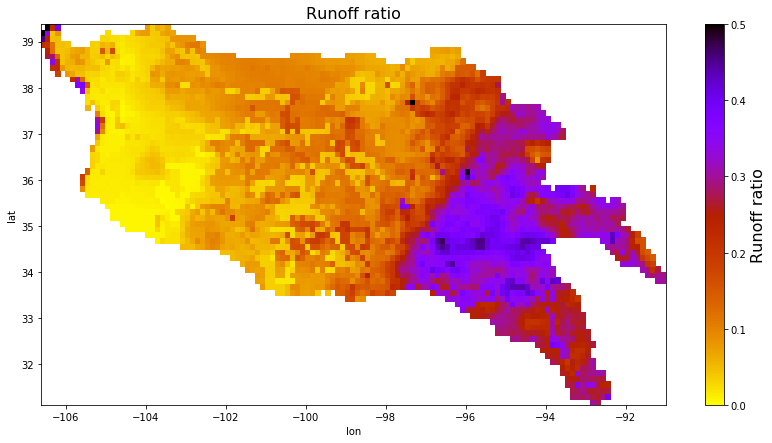

In [27]:
# --- Plot long-term runoff ratio --- #
fig = plt.figure(figsize=(14, 7))
da_runoff_ratio = da_totrunoff_daily.mean(dim='time') / \
                  da_prec_daily.mean(dim='time')
cs = da_runoff_ratio.plot(vmin=0, vmax=0.5, cmap='gnuplot_r', add_colorbar=False)
cbar = plt.colorbar(cs).set_label('Runoff ratio', fontsize=16)
plt.title('Runoff ratio', fontsize=16)
fig.savefig(os.path.join(output_dir, 'ArkRed.runoff_ratio.png'),
            format='png', bbox_inches='tight', pad_inches=0)
print(da_runoff_ratio.median())  # Domain-median runoff ratio

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="sum", instead consider using .resample(time="1Y").sum() 
  This is separate from the ipykernel package so we can avoid doing imports until
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


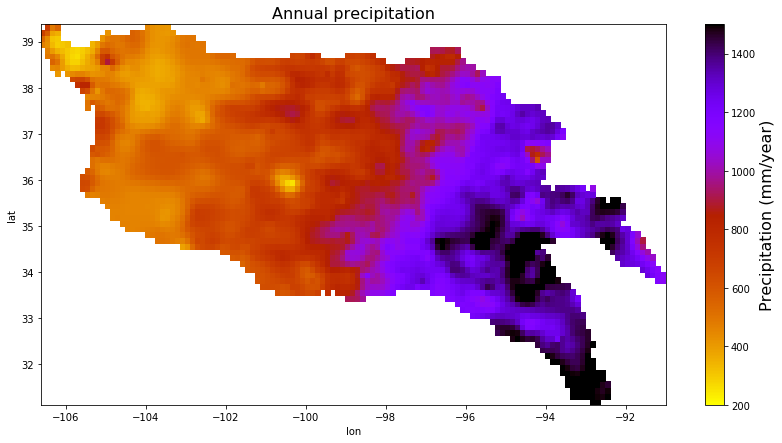

In [28]:
# Annual precipitation
fig = plt.figure(figsize=(14, 7))
da_prec_annual = da_prec_daily.resample('1Y', dim='time', how='sum').mean(dim='time')  # [mm/year]
cs = da_prec_annual.where(da_domain).plot(cmap='gnuplot_r', add_colorbar=False,
                                          vmin=200, vmax=1500)
cbar = plt.colorbar(cs).set_label('Precipitation (mm/year)', fontsize=16)
plt.title('Annual precipitation', fontsize=16)
fig.savefig(os.path.join(output_dir, 'ArkRed.prec_annual.png'),
            format='png', bbox_inches='tight', pad_inches=0)

In [31]:
da_totrunoff_annual.where(da_domain).mean()

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


<xarray.DataArray ()>
array(157.616789)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="sum", instead consider using .resample(time="1Y").sum() 
  
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


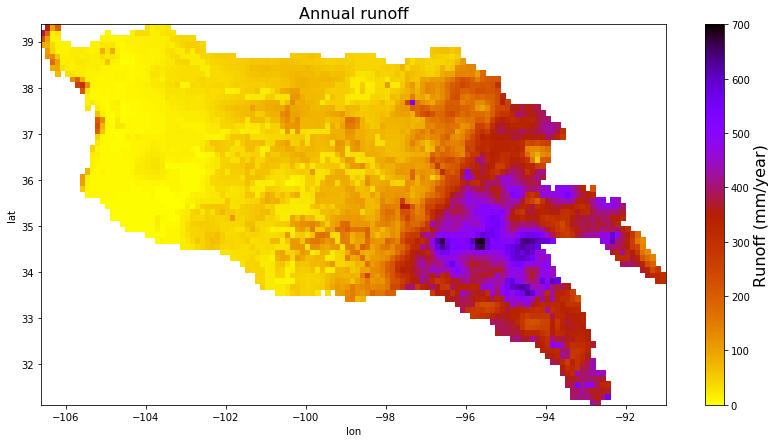

In [29]:
fig = plt.figure(figsize=(14, 7))
da_totrunoff_annual = da_totrunoff_daily.resample('1Y', dim='time', how='sum').mean(dim='time')  # [mm/year]
cs = da_totrunoff_annual.where(da_domain).plot(cmap='gnuplot_r', add_colorbar=False,
                                               vmin=0, vmax=700)
cbar = plt.colorbar(cs).set_label('Runoff (mm/year)', fontsize=16)
plt.title('Annual runoff', fontsize=16)
fig.savefig(os.path.join(output_dir, 'ArkRed.runoff_annual.png'),
            format='png', bbox_inches='tight', pad_inches=0)

In [14]:
# --- Convert ArkRed-domain-avg runoff to m3/s --- #
ts_runoff_ArkRed = (da_totrunoff_daily * da_area).sum(dim='lat').sum(dim='lon').to_series()  # [mm*m2/day]
ts_runoff_ArkRed = ts_runoff_ArkRed / 86400 / 1000  # convert to m3/s
ts_runoff_ArkRed.mean()

3613.8909477058173

In [15]:
ts_surfacerunoff_ArkRed = (da_surfacerunoff_daily * da_area).sum(dim='lat').sum(dim='lon').to_series()  # [mm*m2/day]
ts_surfacerunoff_ArkRed = ts_surfacerunoff_ArkRed / 86400 / 1000  # convert to m3/s
print('Surface runoff:', ts_surfacerunoff_ArkRed.mean())
ts_baseflow_ArkRed = (da_baseflow_daily * da_area).sum(dim='lat').sum(dim='lon').to_series()  # [mm*m2/day]
ts_baseflow_ArkRed = ts_baseflow_ArkRed / 86400 / 1000  # convert to m3/s
print('Baseflow:', ts_baseflow_ArkRed.mean())

Surface runoff: 1515.1946981471
Baseflow: 2098.696249558717


In [17]:
# --- USGS approximate ArkRed-domain-avg runoff --- #
ts_usgs_Red = read_USGS_data('/civil/hydro/ymao/data_assim/data/USGS/USGS_big_sites/07344370_Red.txt',
                             columns=[1], names=['flow'])['flow']\
              .truncate(before='2015-03-31', after='2017-12-31')
ts_usgs_Ark = read_USGS_data('/civil/hydro/ymao/data_assim/data/USGS/USGS_big_sites/07250551_Ark.txt',
                             columns=[1], names=['flow'])['flow']\
              .truncate(before='2015-03-31', after='2017-12-31')
ts_usgs_ArkRed = (ts_usgs_Red + ts_usgs_Ark)  # [cfs]
ts_usgs_ArkRed = ts_usgs_ArkRed * np.power(12 * 25.4 / 1000, 3)  # convert to m3/s
ts_usgs_ArkRed.dropna().mean()

1391.8493741379305

In [10]:
# --- Basin domain --- #
dict_da_frac = {}
for site in dict_sites.keys():
    da_frac = xr.open_dataset(
        '/civil/hydro/ymao/data_assim/param/RVIC/ArkRed/parameter/'
        'param_run_output.8sites_Crow2017/temp/remapped/remapUH_{}.nc'.format(site))['fraction']
    dict_da_frac[site] = da_frac

In [11]:
# --- Basin area --- #
dict_basin_area = {}
for site in dict_sites.keys():
    basin_area = float(da_area.where(dict_da_frac[site]>0).sum())  # [m2]
    basin_area = basin_area / 1000 / 1000  # convert to [km2]
    dict_basin_area[site] = basin_area
    print(site, basin_area)

ninnescah 1983.1028074048015
spring 5075.144257650728
chikaskia 4310.18946663719
bird 3103.7095348407056
illinois 3276.8724308692413
arkansas 3489.61244685949
deep 4863.3081974647885
walnut 5043.581406236542


/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [12]:
# --- Calculate basin-sum runoff and precipitation --- #
dict_ts_basin_sum = {}
dict_ts_basin_prec = {}
for site in dict_sites.keys():
    # Runoff sum
    da_basin = da_totrunoff_daily.where(dict_da_frac[site]>0)
    ts_basin_sum = (da_basin * da_area).sum(dim='lat').sum(dim='lon').to_series()  # [mm*m2/day]
    ts_basin_sum = ts_basin_sum / (dict_basin_area[site] * 1000 * 1000)  # convert to [mm/day]
    dict_ts_basin_sum[site] = ts_basin_sum
    # Precipitation sum
    da_basin_prec = da_prec_daily.where(dict_da_frac[site]>0)
    ts_basin_prec = (da_basin_prec * da_area).sum(dim='lat').sum(dim='lon').to_series()  # [mm*m2/day]
    ts_basin_prec = ts_basin_prec / (dict_basin_area[site] * 1000 * 1000)  # convert to [mm/day]
    dict_ts_basin_prec[site] = ts_basin_prec

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [13]:
# --- USGS drainage area (mi2) --- #
dict_usgs_drainage_area = {}  # {site: area}
for i in df_site_info.index:
    site = df_site_info.loc[i, 'short_name']
    drainage_area = df_site_info.loc[i, 'drain_area_va']
    dict_usgs_drainage_area[site] = drainage_area * 1.60934 * 1.60934  # convert [mi2] to [km2]

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  This is separate from the ipykernel package so we can avoid doing imports until
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  import sys


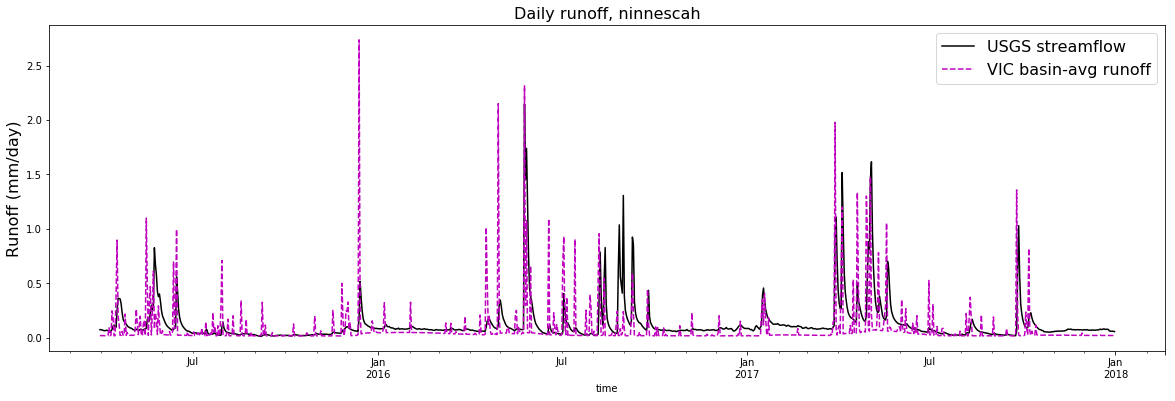

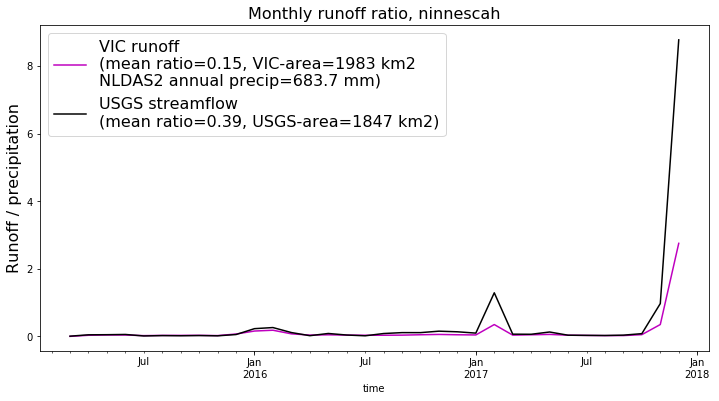

In [16]:
# Plot daily time series and monthly runoff ratio
for site in dict_sites.keys():
    # --- Calculate stats --- #
    ts_runoff_sum_monthly = dict_ts_basin_sum[site].resample('1M', how='sum')
    ts_usgs_flow = dict_flow_usgs[site]  # [cfs]
    ts_usgs_flow = ts_usgs_flow * np.power(25.4*12/1000, 3) * 86400 / \
                   (dict_basin_area[site] * 1000 * 1000) * 1000  # convert cfs to mm/day
    ts_runoff_usgs_monthly = ts_usgs_flow.resample('1M', how='sum')
    ts_prec_monthly = dict_ts_basin_prec[site].resample('1M', how='sum')
    ts_runoff_ratio_monthly = ts_runoff_sum_monthly / ts_prec_monthly
    ts_runoff_ratio_monthly_usgs = ts_runoff_usgs_monthly / ts_prec_monthly
    # 
    
    # Plot daily time series
    fig = plt.figure(figsize=(20, 6))
    ts_usgs_flow.plot(color='k', label='USGS streamflow')
    dict_ts_basin_sum[site].plot(color='m', style='--', label='VIC basin-avg runoff')
    # Make plot better
    plt.ylabel('Runoff (mm/day)', fontsize=16)
    plt.title('Daily runoff, {}'.format(site), fontsize=16)
    plt.legend(fontsize=16)
    # Save to file
    fig.savefig(os.path.join(output_dir, 'vic_basin_runoff.{}.png'.format(site)),
                format='png', bbox_inches='tight', pad_inches=0)
    
    # Plot monthly runoff ratio
    fig = plt.figure(figsize=(12, 6))
    ts_runoff_ratio_monthly.plot(
        color='m',
        label='VIC runoff\n'
              '(mean ratio={:.2f}, VIC-area={:.0f} km2\nNLDAS2 annual precip={:.1f} mm)'.format(
                    ts_runoff_ratio_monthly.mean(),
                    dict_basin_area[site],
                    dict_ts_basin_prec[site].mean()*365))
    ts_runoff_ratio_monthly_usgs.plot(
        color='k',
        label='USGS streamflow\n(mean ratio={:.2f}, USGS-area={:.0f} km2)'.format(
            ts_runoff_ratio_monthly_usgs.mean(),
            dict_usgs_drainage_area[site]))
    # Make plot better
    plt.ylabel('Runoff / precipitation', fontsize=16)
    plt.title('Monthly runoff ratio, {}'.format(site), fontsize=16)
    plt.legend(fontsize=16)
    # Save to file
    fig.savefig(os.path.join(output_dir, 'runoff_ratio_monthly.{}.png'.format(site)),
                format='png', bbox_inches='tight', pad_inches=0)
    
    break

## Functions

In [2]:
def read_RVIC_output(filepath, output_format='array', outlet_ind=-1):
    ''' This function reads RVIC output netCDF file

    Input:
        filepath: path of the output netCDF file
        output_format: 'array' or 'grid' (currently only support 'array')
        outlet_ind: index of the outlet to be read (index starts from 0); -1 for reading all outlets

    Return:
        df - a DataFrame containing streamflow [unit: cfs]; column name(s): outlet name
        dict_outlet - a dictionary with outlet name as keys; [lat lon] as content

    '''
    
    ds = xr.open_dataset(filepath)

    #=== Read in outlet names ===#
    outlet_names = [outlet_name.decode('utf-8')
                    for outlet_name in ds['outlet_name'].values]

    #=== Read in outlet lat lon ===#
    dict_outlet = {}
    # If read all outlets
    if outlet_ind==-1:
        for i, name in enumerate(outlet_names):
            dict_outlet[name] = [ds['lat'].values[i], ds['lon'].values[i]]
    # If read one outlet
    else:
        dict_outlet[outlet_names[outlet_ind]] = \
                        [ds['lat'].values[outlet_ind], ds['lon'].values[outlet_ind]]

    #=== Read in streamflow variable ===#
    flow = ds['streamflow'].values
    flow = flow * np.power(1000/25.4/12, 3)  # convert m3/s to cfs
    # If read all outlets
    if outlet_ind==-1:
        df = pd.DataFrame(flow, index=ds.coords['time'].values, columns=outlet_names)
    # If read one outlet
    else:
        df = pd.DataFrame(flow[:,outlet_ind], index=ds.coords['time'].values, \
                          columns=[outlet_names[outlet_ind]])

    return df, dict_outlet

In [3]:
def read_USGS_data(file, columns, names):
    '''This function reads USGS streamflow from the directly downloaded format (date are in the 3rd columns)

    Input:
        file: directly downloaded streamflow file path [str]
        columns: a list of data colomn numbers, starting from 1.
            E.g., if the USGS original data has three variables: max_flow, min_flow,
            mean_flow, and the desired variable is mean_flow, then columns = [3]
        names: a list of data column names. E.g., ['mean_flow']; must the same length as columns

    Return:
        a pd.DataFrame object with time as index and data columns (NaN for missing data points)

    Note: returned data and flow might not be continuous if there is missing data!!!

    '''
    ndata = len(columns)
    if ndata != len(names):  # check input validity
        raise ValueError("Input arguments 'columns' and 'names' must have same length!")

    f = open(file, 'r')
    date_array = []
    data = []
    for i in range(ndata):
        data.append([])
    while 1:
        line = f.readline().rstrip("\n")  # read in one line
        if line=="":
                break
        line_split = line.split('\t')
        if line_split[0]=='USGS':  # if data line
                date_string = line_split[2]  # read in date string
                date = dt.datetime.strptime(date_string, "%Y-%m-%d")  # convert date to dt object
                date_array.append(date)

                for i in range(ndata):  # for each desired data variable
                        col = columns[i]
                        if line_split[3+(col-1)*2] == '':  # if data is missing
                                value = np.nan
                        elif line_split[3+(col-1)*2] == 'Ice':  # if data is 'Ice'
                                value = np.nan
                        else:  # if data is not missing
                                value = float(line_split[3+(col-1)*2])
                        data[i].append(value)

    data = np.asarray(data).transpose()
    df = pd.DataFrame(data, index=date_array, columns=names)
    return df

In [4]:
def kge(sim, obs):
    ''' Calculate Kling-Gupta Efficiency (function from Oriana) '''

    std_sim = np.std(sim)
    std_obs = np.std(obs)
    mean_sim = sim.mean(axis=0)
    mean_obs = obs.mean(axis=0)
    r_array = np.corrcoef(sim.values, obs.values)
    r = r_array[0,1]
    relvar = std_sim/std_obs
    bias = mean_sim/mean_obs
    kge = 1-np.sqrt(np.square(r-1) + np.square(relvar-1) + np.square(bias-1))
    return kge

In [5]:
def nse(sim, obs):
    ''' Calcualte Nash–Sutcliffe efficiency'''
    
    obs_mean = np.mean(obs)
    nse = 1 - np.sum(np.square(sim - obs)) / np.sum(np.square(obs - obs_mean))
    return nse

In [6]:
def rmse(true, est):
    ''' Calculates RMSE of an estimated variable compared to the truth variable

    Parameters
    ----------
    true: <np.array>
        A 1-D array of time series of true values
    est: <np.array>
        A 1-D array of time series of estimated values (must be the same length of true)

    Returns
    ----------
    rmse: <float>
        Root mean square error

    Require
    ----------
    numpy
    '''

    rmse = np.sqrt(sum((est - true)**2) / len(true))
    return rmse

In [7]:
def crps(truth, ensemble):
    ''' Calculate mean CRPS of an ensemble time series
    Parameters
    ----------
    truth: <np.array>
        A 1-D array of truth time series
        Dimension: [n]
    ensemble: <np.array>
        A 2-D array of ensemble time series
        Dimension: [n, N], where N is ensemble size; n is time series length
        
    Returns
    ----------
    crps: <float>
        Time-series-mean CRPS
        
    Require
    ----------
    import properscoring as ps
    '''
    
    array_crps = np.asarray([ps.crps_ensemble(truth[t], ensemble[t, :]) for t in range(len(truth))])
    crps = array_crps.mean()
    
    return crps

In [8]:
def bias_ensemble_norm_var(truth, ensemble):
    ''' Calculate variance of normalized bias of an ensemble time series.
    Specifically, at each time step t, mean bias is normalized by ensemble spread:
            bias_norm(t) = mean_bias / std(ensemble)
    Then average over all time steps:
            bias_norm = mean(bias_norm(t))
            
    Parameters
    ----------
    truth: <np.array>
        A 1-D array of truth time series
        Dimension: [n]
    ensemble: <np.array>
        A 2-D array of ensemble time series
        Dimension: [n, N], where N is ensemble size; n is time series length
        
    Returns
    ----------
    bias_ensemble_norm_var: <float>
        Time-series-mean ensemble-normalized bias
        
    Require
    ----------
    import properscoring as ps
    '''
    
    mean_bias = ensemble.mean(axis=1) - truth  # [n]
    std_ensemble = ensemble.std(axis=1)  # [n]
    bias_ensemble_norm_var = (mean_bias / std_ensemble).var()
    
    return bias_ensemble_norm_var

In [9]:
def nensk(truth, ensemble):
    ''' Calculate the ratio of temporal-mean ensemble skill to temporal-mean ensemble spread:
            nensk = <ensk> / <ensp>
    where <ensk> is temporal average of: ensk(t) = (ensmean - truth)^2
          <ensp> is temperal average of: ensp(t) = mean((ens_i - ensmean)^2) = var(ens_i)

    Parameters
    ----------
    truth: <np.array>
        A 1-D array of truth time series
        Dimension: [n]
    ensemble: <np.array>
        A 2-D array of ensemble time series
        Dimension: [n, N], where N is ensemble size; n is time series length

    Returns
    ----------
    nensk: <float>
        Normalized ensemble skill
    '''

    ensk = np.square((ensemble.mean(axis=1) - truth))  # [n]
    ensp = ensemble.var(axis=1)  # [n]
    nensk = np.mean(ensk) / np.mean(ensp)

    return nensk